# How does the constraints on the feasible space effect error?
## Toy Model

### Set up:

We examine the imapact of noising and readjusting demographic tabular data from a precinct.

Given demographic information of a unit, we then add Laplace noise to those counts and project the noised values onto the nearest point in the space defined by the constraints defined below.  The [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.minimize.html) function is used to optimize the reprojection, and the objective function is the L1 norm of the difference from the noised point.

#### Constraints:

* 0 difference constraints: 
    * TOTPOP = $\Sigma_x$ xPOP
    * VAP = $\Sigma_x$ xVAP
* Subset constraints
    * VAP $\leq$ TOTPOP
    * xVAP $\leq$ xPOP $\forall$ x
    
### Questions

* How does the adjusted error from truth change with different sets of constraints?
* How does adjusting the scale of the noise affect that?


### TODO:
* Create datafame with error for seperate demographics and diff epsilons to see trends
    * Columns: $\lambda$, $\epsilon$, count, mean error, percent error, num samps 

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

In [2]:
df = gpd.read_file("/cluster/home/jmatth03/Georgia/GA_precincts16/GA_precincts16.shp")

In [3]:
keys = ['TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN','NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP',
        'VAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP','HVAP']

In [4]:
samp0 = df[keys].iloc[20]
samp1 = df[keys].iloc[21]

In [5]:
test = np.random.laplace(scale=50, size=10000)

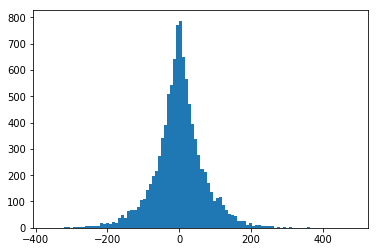

In [6]:
plt.hist(test, bins=100)
plt.show()

#### L1 error of noised from truth as a function of epsilon

In [242]:
num_samps = 1000

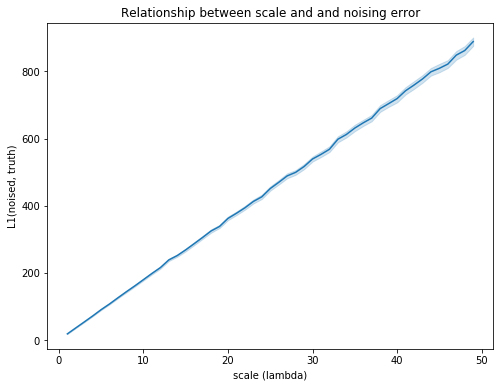

In [449]:
plt.figure(figsize=(8,6))
plt.title("Relationship between scale and and noising error")
plt.xlabel("scale (lambda)")
plt.ylabel("L1(noised, truth)")
ls = np.arange(1,50) ## laplace scale = sensitivity / eps
ns = [np.random.laplace(scale=l, size=(num_samps,18)) for l in ls]
ers = np.array([sp.linalg.norm(n, ord=1, axis=1) for n in ns]).flatten()
sns.lineplot(x=np.repeat(ls, num_samps), y=ers, )#ci="sd")
plt.savefig("plots/truth_noise_scale_nsamp_1000.png", bbox_inches="tight", dpi=200)
plt.show()

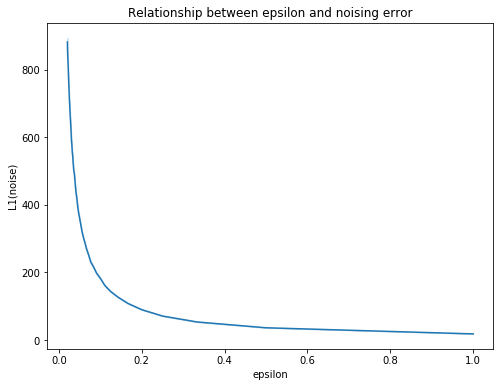

In [450]:
plt.figure(figsize=(8,6))
plt.title("Relationship between epsilon and noising error")
plt.xlabel("epsilon")
plt.ylabel("L1(noise)")
ls = np.arange(1,50)
eps = 1 / ls ## laplace scale = sensitivity / eps
ns = [np.random.laplace(scale=l, size=(num_samps,18)) for l in ls]
ers = np.array([sp.linalg.norm(n, ord=1, axis=1) for n in ns]).flatten()
sns.lineplot(x=np.repeat(eps, num_samps), y=ers, )#ci="sd")
plt.savefig("plots/truth_noise_epsilon_nsamp_1000.png", bbox_inches="tight", dpi=200)
plt.show()

#### Effects of Constrainst

In [86]:
truth = samp0.values

In [100]:
# Set up configuration parameters

## Objective function: when passed a noised value n, returns a function to compute the L1 
## distance between the input x and that noised point.
fun = lambda n: lambda x: sp.linalg.norm(x-n, ord=1)

## Bounds: All categories should be non-negative
bnds = [(0, None)]*18

## Constraints: 0 difference among partition bins, vap counts smaller than total pop, and both.
cons_0_diff = [{'type': 'eq', 'fun': lambda x:  x[0] - np.sum([x[i] for i in range(1,9)])},
               {'type': 'eq', 'fun': lambda x:  x[9] - np.sum([x[i] for i in range(10,18)])}]

cons_vap_lt_pop = []
for i in range(0,9):
    cons_vap_lt_pop.append({"type": "ineq", "fun": lambda x,i=i: x[i] - x[i+9]})
    
cons = cons_0_diff + cons_vap_lt_pop

In [88]:
## Noises the truth point, and then reprojects the noised point into the feasible space,
## as defined by the past objective function f, constraints, and bounds.
## Returns a tuple containing the`scipy.optimize.optimize.OptimizeResult` and 
## the noised point

def noise_and_readjust(truth, scale, f, constrainsts, bounds):
    shape = truth.shape
    noise = np.random.laplace(scale=scale, size=shape)
    noised = truth + noise
    res = minimize(f(noised), truth, constraints=constrainsts, bounds=bounds)
    return res
    #return (res, noised)

In [89]:
def sample_distance_from_adj(ls, n_samps, truth, f, cons, bnds, record=False):
    l1s_adj_noised = np.zeros((len(ls), n_samps))
    l1s_adj_truth = np.zeros((len(ls), n_samps))
    adjs = np.zeros((len(ls), n_samps, len(truth)))

    for i,l in enumerate(ls):
        for j in range(n_samps):
            adj = noise_and_readjust(truth=truth, scale=l, f=f, constrainsts=cons, bounds=bnds)
            if record: adjs[i][j] = adj.x
            l1s_adj_noised[i][j] = (adj.fun)
            l1s_adj_truth[i][j] = (sp.linalg.norm(truth-adj.x, ord=1))
    if not record:
        return(l1s_adj_noised, l1s_adj_truth)
    else:
        return(l1s_adj_noised, l1s_adj_truth, adjs)

In [102]:
noise_and_readjust(parent_truth, 5, fun, cons, bnds)

     fun: 45.48069067259108
     jac: array([ 1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.])
 message: 'Optimization terminated successfully.'
    nfev: 143
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([6.82933846e+03, 2.99938198e+03, 2.88003876e+03, 1.13592598e+01,
       5.20573107e+02, 5.74285005e+00, 2.03592598e+01, 1.23807906e+02,
       2.68075347e+02, 5.25889628e+03, 2.57715732e+03, 2.04767779e+03,
       5.03313580e+00, 3.70126440e+02, 5.74285005e+00, 2.28983499e-16,
       7.08241610e+01, 1.82334575e+02])

In [16]:
n_samps = 100
ls = np.arange(1,50)

(l1s_adj_noised, l1s_adj_truth) = sample_distance_from_adj(ls, n_samps, truth, fun, cons, bnds)    
(l1s_adj_noised_0diff, l1s_adj_truth_0diff) = sample_distance_from_adj(ls, n_samps, truth, fun, 
                                                                       cons_0_diff, bnds)
(l1s_adj_noised_subset, l1s_adj_truth_subset) = sample_distance_from_adj(ls, n_samps, truth, fun, 
                                                                         cons_vap_lt_pop, bnds)   

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8,6))
plt.title("Relationship bewteen contraints and adjustment scale")
plt.xlabel("Scale")
plt.ylabel("L1(adjusted, noised)")

sns.lineplot(y=l1s_adj_noised.flatten(), x=np.repeat(ls, n_samps), #ci="sd", 
             label="all constraints")
sns.lineplot(y=l1s_adj_noised_0diff.flatten(), x=np.repeat(ls, n_samps),  #ci="sd",
             label="0 diff constraints")
sns.lineplot(y=l1s_adj_noised_subset.flatten(), x=np.repeat(ls, n_samps),  #ci="sd",
             label="VAP <= POP contraints")

plt.legend()
plt.savefig("plots/adj_noise_scale_50_nsamp_{}.png".format(n_samps), 
            bbox_inches="tight", dpi=200)
plt.show()

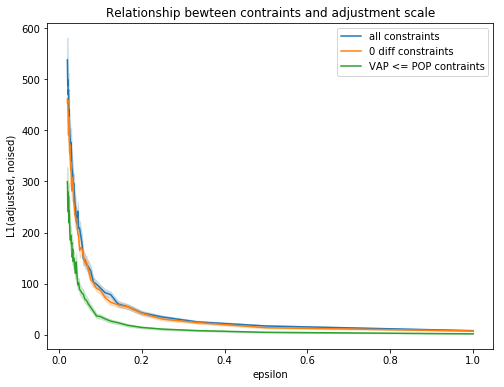

In [132]:
plt.figure(figsize=(8,6))
plt.title("Relationship bewteen contraints and adjustment scale")
plt.xlabel("epsilon")
plt.ylabel("L1(adjusted, noised)")
eps = 1/ls

sns.lineplot(y=l1s_adj_noised.flatten(), x=np.repeat(eps, n_samps),  #ci="sd",
             label="all constraints")
sns.lineplot(y=l1s_adj_noised_0diff.flatten(), x=np.repeat(eps, n_samps),  #ci="sd",
             label="0 diff constraints")
sns.lineplot(y=l1s_adj_noised_subset.flatten(), x=np.repeat(eps, n_samps), #ci="sd",
             label="VAP <= POP contraints")

plt.legend()
plt.savefig("plots/adj_noise_epsilon_1_50_nsamp_{}.png".format(n_samps), 
            bbox_inches="tight", dpi=200)
plt.show()

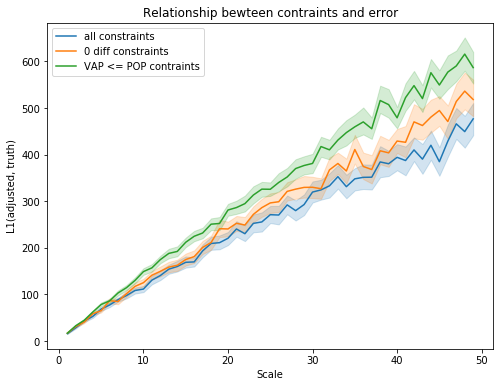

In [133]:
plt.figure(figsize=(8,6))
plt.title("Relationship bewteen contraints and error")
plt.xlabel("Scale")
plt.ylabel("L1(adjusted, truth)")

sns.lineplot(y=l1s_adj_truth.flatten(), x=np.repeat(ls, n_samps),  #ci="sd",
             label="all constraints")
sns.lineplot(y=l1s_adj_truth_0diff.flatten(), x=np.repeat(ls, n_samps),  #ci="sd",
             label="0 diff constraints")
sns.lineplot(y=l1s_adj_truth_subset.flatten(), x=np.repeat(ls, n_samps),  #ci="sd",
             label="VAP <= POP contraints")

plt.savefig("plots/adj_truth_scale_50_nsamp_{}.png".format(n_samps), 
            bbox_inches="tight", dpi=200)
plt.legend()
plt.show()

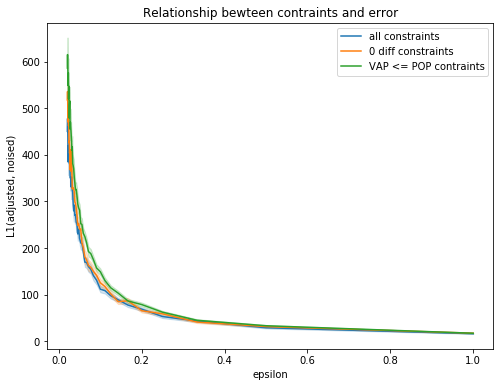

In [134]:
plt.figure(figsize=(8,6))
plt.title("Relationship bewteen contraints and error")
plt.xlabel("epsilon")
plt.ylabel("L1(adjusted, noised)")
eps = 1/ls

sns.lineplot(y=l1s_adj_truth.flatten(), x=np.repeat(eps, n_samps),  #ci="sd",
             label="all constraints")
sns.lineplot(y=l1s_adj_truth_0diff.flatten(), x=np.repeat(eps, n_samps),  #ci="sd",
             label="0 diff constraints")
sns.lineplot(y=l1s_adj_truth_subset.flatten(), x=np.repeat(eps, n_samps),  #ci="sd",
             label="VAP <= POP contraints")

plt.savefig("plots/adj_truth_epsilon_1_50_nsamp_{}.png".format(n_samps), 
            bbox_inches="tight", dpi=200)
plt.legend()
plt.show()

In [340]:
noise_and_readjust(truth=truth, scale=25, f=fun, constrainsts=cons, bounds=bnds)

     fun: 177.71509601041933
     jac: array([ 1., -1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,
       -1.,  1., -1., -1., -1.])
 message: 'Optimization terminated successfully.'
    nfev: 142
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([2903.7627398 , 1124.88989666, 1432.27440437,   15.27440437,
        215.13474227,    0.        ,   20.27440437,   28.67561875,
         67.239269  , 2249.5554218 ,  960.48172238, 1024.58315967,
          0.        ,  170.48172238,    0.        ,    8.48172238,
         27.04537262,   58.48172238])

## Differential effects on columns

* Columns: $\lambda$, $\epsilon$, count, mean error, percent error, num samps 

In [94]:
ls = np.arange(1,25)
(_,_,adjs) = sample_distance_from_adj(ls, 50, truth, fun, cons, bnds, record=True)

In [95]:
adjs.shape

(24, 50, 18)

In [97]:
d = {"scale": np.zeros(adjs.shape),
     "epsilon": np.zeros(adjs.shape),
     "col": np.full(adjs.shape, "", dtype=object),
#      "true_count": np.zeros((len(ls), len(keys))),
#      "adj_count": np.zeros((len(ls), len(keys))),
     "abs_error": np.zeros(adjs.shape),
     "perc_error": np.zeros(adjs.shape),
     "num_samps": np.full(adjs.shape, 50),}

for i,l in enumerate(ls):
    d["scale"][i] = l
    d["epsilon"][i] = 1/l
    for j,k in enumerate(keys):
        d["col"][i,:,j] = k
#         d["true_count"][i][j] = samp[k]
#         d["adj_count"][i][j] = adjs[i,:,j]
        err = samp[k] - adjs[i,:,j]
        d["abs_error"][i,:,j] = np.abs(err)
        d["perc_error"][i,:,j] = np.abs(err) / samp[k]
#         print("\t+- {:.4f}".format(np.mean(np.abs(err))))
#         print("\t{:.4%}".format(np.mean(np.abs(err)) / samp[k]))

In [98]:
col_err = pd.DataFrame({k: v.flatten() for k,v in d.items()})

In [99]:
col_err.head()

,scale,epsilon,col,abs_error,perc_error,num_samps
0,1.0,1.0,TOTPOP,0.445197,0.000154,50
1,1.0,1.0,NH_WHITE,1.351365,0.001211,50
2,1.0,1.0,NH_BLACK,1.327573,0.000935,50
3,1.0,1.0,NH_AMIN,1.589182,0.529727,50
4,1.0,1.0,NH_ASIAN,1.351365,0.006466,50


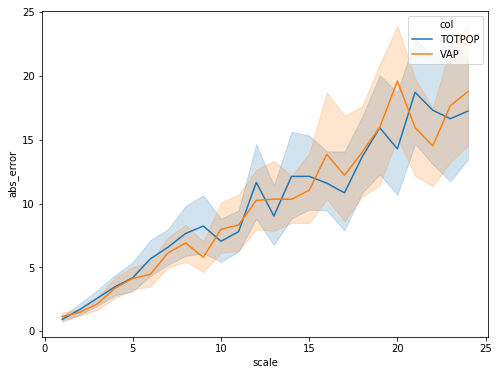

In [105]:
plt.figure(figsize=(8,6))
sns.lineplot(data=col_err, x="scale", y="abs_error", hue="col", 
             hue_order=["TOTPOP", "VAP", ])
plt.show()

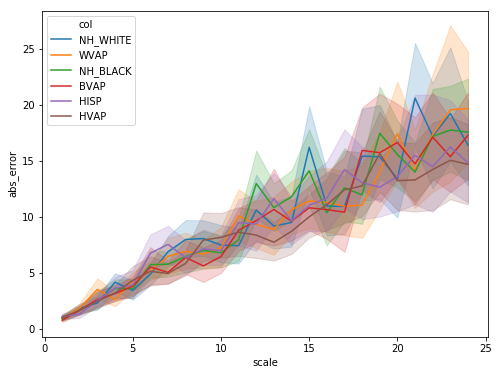

In [107]:
plt.figure(figsize=(8,6))
sns.lineplot(data=col_err, x="scale", y="abs_error", hue="col", 
             hue_order=["NH_WHITE", "WVAP", "NH_BLACK", "BVAP","HISP", "HVAP"])
plt.show()

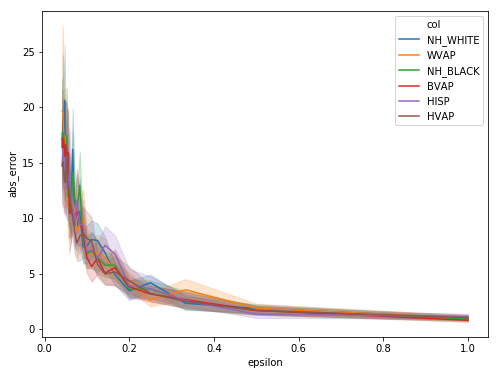

In [101]:
plt.figure(figsize=(8,6))
sns.lineplot(data=col_err, x="epsilon", y="abs_error", hue="col", 
             hue_order=["NH_WHITE", "WVAP", "NH_BLACK", "BVAP","HISP", "HVAP"])
plt.show()

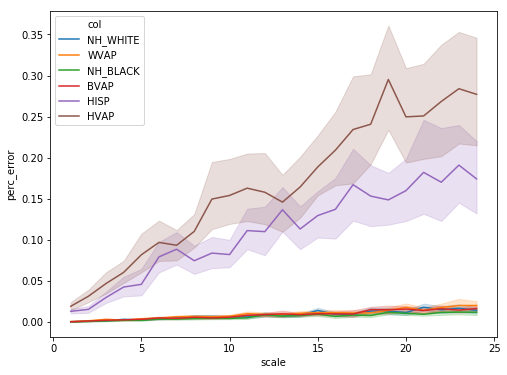

In [112]:
plt.figure(figsize=(8,6))
sns.lineplot(data=col_err, x="scale", y="perc_error", hue="col", 
             hue_order=["NH_WHITE", "WVAP", "NH_BLACK", "BVAP","HISP", "HVAP"])
plt.show()

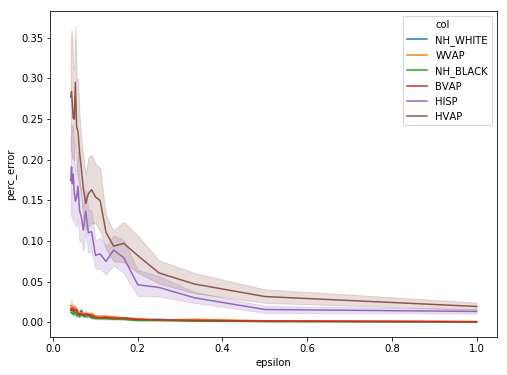

In [103]:
plt.figure(figsize=(8,6))
sns.lineplot(data=col_err, x="epsilon", y="perc_error", hue="col", 
             hue_order=["NH_WHITE", "WVAP", "NH_BLACK", "BVAP","HISP", "HVAP"])
plt.show()

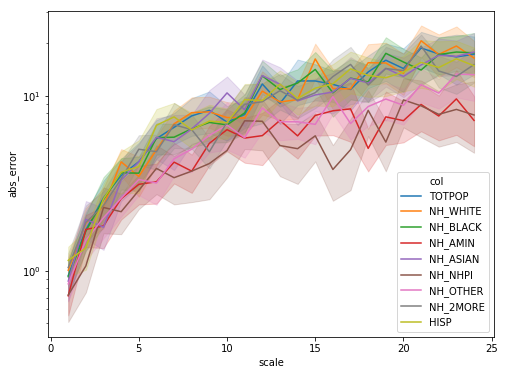

In [121]:
plt.figure(figsize=(8,6))
sns.lineplot(data=col_err, x="scale", y="abs_error", hue="col",
             hue_order=['TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 
                        'NH_ASIAN','NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP',])
plt.yscale('log')
plt.show()

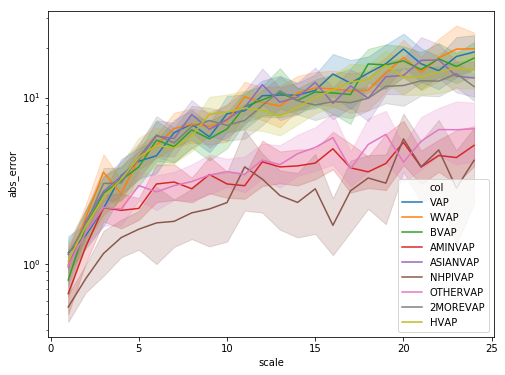

In [125]:
plt.figure(figsize=(8,6))
sns.lineplot(data=col_err, x="scale", y="abs_error", hue="col",
             hue_order=['VAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 
                        'NHPIVAP', 'OTHERVAP', '2MOREVAP','HVAP'])
plt.yscale('log')
plt.show()

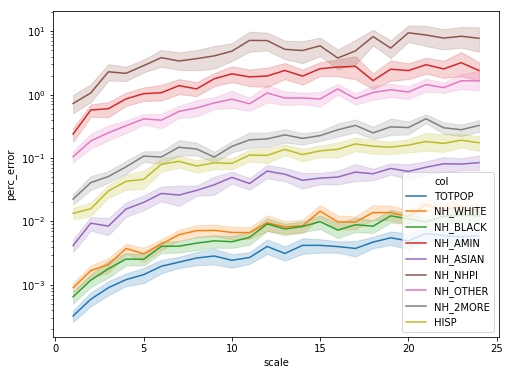

In [119]:
plt.figure(figsize=(8,6))
sns.lineplot(data=col_err, x="scale", y="perc_error", hue="col",
             hue_order=['TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 
                        'NH_ASIAN','NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP',])
plt.yscale('log')
plt.show()

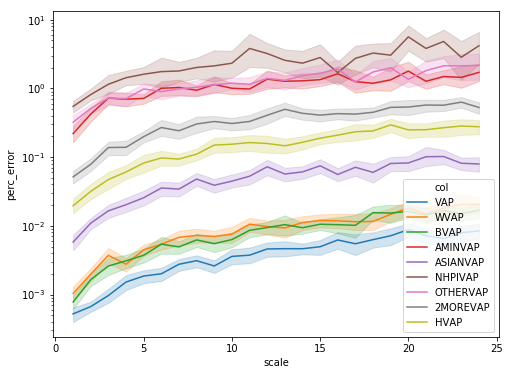

In [127]:
plt.figure(figsize=(8,6))
sns.lineplot(data=col_err, x="scale", y="perc_error", hue="col",
             hue_order=['VAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 
                        'NHPIVAP', 'OTHERVAP', '2MOREVAP','HVAP'])
plt.yscale('log')
plt.show()

## Multiple Levels of the Hierarchy

#### Data

* parent = $[x_0, x_1, ..., x_{k}]$
* child_0 = $[x_{0,0}, x_{1,0}, ..., x_{k,0}]$
* child_1 = $[x_{0,1}, x_{1,1}, ..., x_{k,1}]$
* children = $[x_{0,0}, x_{1,0}, ..., x_{k,0}, x_{0,1}, x_{1,1}, ..., x_{k,1}, ..., x_{0,n}, x_{1,n}, ..., x_{k,n}]$

With $k$ variables and $n$ children.  parent has length $k$, and children has length $kn$

Here there are 18 vars and 2 children.

#### Constraints

* 0 difference among partition bins:
    * $x[i]$ - $\Sigma$ $x[j] = 0$, $\forall j $ st. $i < j < i + 9 $
* VAP $\leq$ TOTPOP
    * $x[i] - x[i+9] \geq 0$, $\forall i $ st. $i \% 18 < 9$
* Children sum to parent in every column.
    * children_sum == parent

In [68]:
np.arange(36)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [126]:
# Set up configuration parameters

# n = 2
# k = 18

## Objective function: when passed a noised value n, returns a function to compute the L1 
## distance between the input x and that noised point.
## - For the childred the L1 distances are summed across siblings.
fun = lambda n: lambda x: sp.linalg.norm(x-n, ord=1)


## Bounds: All categories should be non-negative.  Passed vector v and retuns bounds matching v's shape.
bnds = lambda v: np.full(list(v.shape) + [2], fill_value=(0, None))

## Constraints: 0 difference among partition bins, vap counts smaller than total pop, and both.
## Passed vector length l, returns list of 0 diff constraints.
cons_0_diff = lambda l: [{'type': 'eq', 'fun': lambda x, i=i:  x[i] - np.sum([x[j] for j in range(i+1,i+9)])} 
                         for i in np.arange(l, step=9)]

cons_vap_lt_pop = lambda l: [{"type": "ineq", "fun": lambda x,i=i: x[i] - x[i+9]} for i in np.arange(l) if i % 18 < 9]
# for i in range(0,9):
#     cons_vap_lt_pop.append({"type": "ineq", "fun": lambda x,i=i: x[i] - x[i+9]})
    
cons = lambda l: cons_0_diff(l) + cons_vap_lt_pop(l)

## Parental Constraints

cons_children = lambda adj_par, n, k: [{'type': 'eq', 'fun': lambda x: np.dot(adj_par - np.sum(x.reshape(n, k), axis=0),
                                                                        adj_par - np.sum(x.reshape(n, k), axis=0))}]

In [143]:
## Noises the truth point, and then reprojects the noised point into the feasible space,
## as defined by the past objective function f, constraints, and bounds.
## Returns a tuple containing the`scipy.optimize.optimize.OptimizeResult` and 
## the noised point

def noise_and_readjust(truth, scale, f, constrainsts, bounds, opts=None):
    shape = truth.shape
    noise = np.random.laplace(scale=scale, size=shape)
    noised = truth + noise
    res = minimize(f(noised), truth, constraints=constrainsts, bounds=bounds, options=opts)
    return res
    #return (res, noised)

In [165]:
def sample_distance_from_adj(ls, n_samps, truth, f, cons, bnds, record=False, opts=None):
    l1s_adj_noised = np.zeros((len(ls), n_samps))
    l1s_adj_truth = np.zeros((len(ls), n_samps))
    adjs = np.zeros((len(ls), n_samps, len(truth)))

    for i,l in enumerate(ls):
        for j in range(n_samps):
            adj = noise_and_readjust(truth=truth, scale=l, f=f, constrainsts=cons, bounds=bnds, opts=opts)
            if record: adjs[i][j] = adj.x
            l1s_adj_noised[i][j] = (adj.fun)
            l1s_adj_truth[i][j] = (sp.linalg.norm(truth-adj.x, ord=1))
    if not record:
        return(l1s_adj_noised, l1s_adj_truth)
    else:
        return(l1s_adj_noised, l1s_adj_truth, adjs)

In [74]:
parent_truth = samp0.values + samp1.values
children_truth = np.append(samp0.values, samp1.values)

In [153]:
noised_children = noise_and_readjust(children_truth, l, fun, child_cons, bnds(children_truth), opts={"maxiter": 200})

In [172]:
n_samps = 10
ls = np.arange(1,5)

noised_par = noise_and_readjust(parent_truth, l, fun, cons(18), bnds(parent_truth))
child_cons = cons(36) + cons_children(noised_par.x, 2, 18)
(l1s_adj_noised, l1s_adj_truth) = sample_distance_from_adj(ls, n_samps, children_truth, fun, child_cons,
                                                           bnds(children_truth), opts={"maxiter": 200})    

noised_par_0_diff = noise_and_readjust(parent_truth, l, fun, cons_0_diff(18), bnds(parent_truth))
child_cons_0_diff = cons_0_diff(36) + cons_children(noised_par_0_diff.x, 2, 18)
(l1s_adj_noised_0_diff, l1s_adj_truth_0_diff) = sample_distance_from_adj(ls, n_samps, children_truth, fun, 
                                                                         child_cons_0_diff, bnds(children_truth), 
                                                                         opts={"maxiter": 200})


noised_par_vap_lt_pop = noise_and_readjust(parent_truth, l, fun, cons_vap_lt_pop(18), bnds(parent_truth))
child_cons_vap_lt_pop = cons_vap_lt_pop(36) + cons_children(noised_par_vap_lt_pop.x, 2, 18)
(l1s_adj_noised_vap_lt_pop, l1s_adj_truth_vap_lt_pop) = sample_distance_from_adj(ls, n_samps, children_truth,
                                                                                 fun, child_cons_vap_lt_pop,
                                                                                 bnds(children_truth), 
                                                                                 opts={"maxiter": 200})  

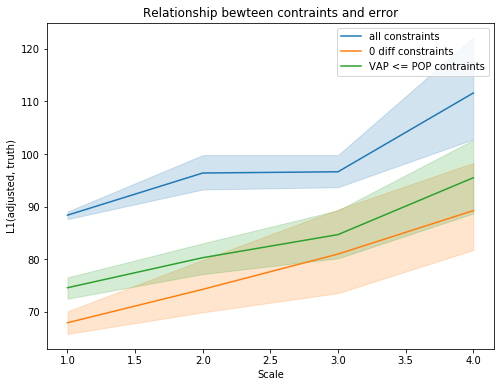

In [173]:
plt.figure(figsize=(8,6))
plt.title("Relationship bewteen contraints and error")
plt.xlabel("Scale")
plt.ylabel("L1(adjusted, truth)")

sns.lineplot(y=l1s_adj_truth.flatten(), x=np.repeat(ls, n_samps),  #ci="sd",
             label="all constraints")
sns.lineplot(y=l1s_adj_truth_0_diff.flatten(), x=np.repeat(ls, n_samps),  #ci="sd",
             label="0 diff constraints")
sns.lineplot(y=l1s_adj_truth_vap_lt_pop.flatten(), x=np.repeat(ls, n_samps),  #ci="sd",
             label="VAP <= POP contraints")

# plt.savefig("plots/adj_truth_scale_50_nsamp_{}.png".format(n_samps), 
#             bbox_inches="tight", dpi=200)
plt.legend()
plt.show()

In [15]:
# ls = np.arange(1,25)

In [16]:


(l1s_adj_noised, l1s_adj_truth) = sample_distance_from_adj(ls, n_samps, truth, fun, cons, bnds)    
(l1s_adj_noised_0diff, l1s_adj_truth_0diff) = sample_distance_from_adj(ls, n_samps, truth, fun, 
                                                                       cons_0_diff, bnds)
(l1s_adj_noised_subset, l1s_adj_truth_subset) = sample_distance_from_adj(ls, n_samps, truth, fun, 
                                                                         cons_vap_lt_pop, bnds)   

KeyboardInterrupt: 

In [11]:
np.array([samp0.values, samp1.values])

array([[2888, 1116, 1420,    3,  209,    1,    8,   46,   85, 2227,  955,
        1025,    3,  165,    1,    3,   22,   53],
       [3939, 1883, 1465,    3,  308,    6,    7,   85,  182, 3030, 1614,
        1017,    2,  212,    5,    3,   48,  129]])

In [12]:
np.sum(children_truth, axis=0)

array([6827, 2999, 2885,    6,  517,    7,   15,  131,  267, 5257, 2569,
       2042,    5,  377,    6,    6,   70,  182])

In [15]:
np.dot(parent_truth - np.sum(children_truth, axis=0),parent_truth - np.sum(children_truth, axis=0))

0

In [18]:
shape = children_truth.shape
noise = np.random.laplace(scale=2, size=shape)
noised = children_truth + noise

In [41]:
sp.linalg.norm(children_truth[0]-noised[0], ord=1)

35.500251194515826

In [24]:
sp.linalg.norm(children_truth[1]-noised[1], ord=1)

44.93383397162823

In [36]:
sp.linalg.norm(children_truth-noised, ord=1, axis=1)

array([35.50025119, 44.93383397])

In [20]:
children_truth

array([[2888, 1116, 1420,    3,  209,    1,    8,   46,   85, 2227,  955,
        1025,    3,  165,    1,    3,   22,   53],
       [3939, 1883, 1465,    3,  308,    6,    7,   85,  182, 3030, 1614,
        1017,    2,  212,    5,    3,   48,  129]])

In [27]:
noised[1]

array([ 3.93672383e+03,  1.88717181e+03,  1.46911856e+03,  2.60255748e+00,
        3.16092498e+02, -2.84482682e+00,  1.11961816e+01,  8.51795540e+01,
        1.83996366e+02,  3.03014747e+03,  1.61053777e+03,  1.01793151e+03,
        2.28051708e+00,  2.11187489e+02,  2.99582465e+00,  3.40368294e+00,
        5.01135404e+01,  1.29504789e+02])

In [480]:
samp

TOTPOP      2888
NH_WHITE    1116
NH_BLACK    1420
NH_AMIN        3
NH_ASIAN     209
NH_NHPI        1
NH_OTHER       8
NH_2MORE      46
HISP          85
VAP         2227
WVAP         955
BVAP        1025
AMINVAP        3
ASIANVAP     165
NHPIVAP        1
OTHERVAP       3
2MOREVAP      22
HVAP          53
Name: 20, dtype: int64

In [349]:
np.mean(l1s_adj_truth)

282.7695260811594

In [357]:
np.zeros((2,n_samps))[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [305]:
adjs = []
for i in range(10):
    noise = np.random.laplace(scale=25, size=(18))
    noised = truth + noise
    fun = lambda x: sp.linalg.norm(x-noised, ord=1)
    res = minimize(fun, truth, constraints=cons, bounds=bnds)
    adjs.append(res.x)

In [269]:
[sp.linalg.norm(truth-adj, ord=1) for adj in adjs]

[219.62824017427175,
 373.0391374173688,
 256.00804386797574,
 336.3379701530549,
 345.4285023429637,
 362.0554341226147,
 380.6033139675351,
 254.3997009380128,
 146.41219594465792,
 309.2450068068877]

In [270]:
[sp.linalg.norm(noised-adj, ord=1) for adj in adjs]

[521.7137624390392,
 586.4258475211864,
 508.1134408296278,
 675.385143374783,
 600.6298919197434,
 707.9992465617246,
 620.2931375772501,
 514.0095134084764,
 445.3604231443914,
 164.9963246553198]

In [16]:
print(sp.linalg.norm(truth-noised, ord=1))

In [260]:
res_0_diff

     fun: 351.58466539589733
     jac: array([-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.])
 message: 'Optimization terminated successfully.'
    nfev: 142
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([2.89309249e+03, 1.11090751e+03, 1.43413124e+03, 2.03980786e+01,
       2.03907510e+02, 2.56252274e-02, 2.90751007e+00, 4.09075101e+01,
       7.99075101e+01, 2.21283322e+03, 9.53634989e+02, 1.01667621e+03,
       0.00000000e+00, 1.60368146e+02, 0.00000000e+00, 0.00000000e+00,
       3.74776622e+01, 4.46762116e+01])

In [139]:
res_0_diff = minimize(fun, truth, constraints=cons_0_diff, bounds=bnds)
res_subset = minimize(fun, truth, constraints=cons_vap_lt_pop, bounds=bnds)
res_both = minimize(fun, truth, constraints=cons, bounds=bnds)

In [151]:
for res in [res_0_diff, res_subset, res_both]:
    print("L1(adj, noised): {}".format(sp.linalg.norm(res.x-noised, ord=1)))
    print("L1(truth, adj): {}".format(sp.linalg.norm(res.x-truth, ord=1)))
    print("L1(truth, noised): {}".format(sp.linalg.norm(noised-truth, ord=1)))
    print()

L1(adj, noised): 351.58466539589733
L1(truth, adj): 122.34751326976507
L1(truth, noised): 433.2315757683534

L1(adj, noised): 170.56736086190958
L1(truth, adj): 262.66423205434717
L1(truth, noised): 433.2315757683534

L1(adj, noised): 351.58466539589745
L1(truth, adj): 122.34751326976493
L1(truth, noised): 433.2315757683534



In [154]:
sp.linalg.norm(noised-truth, ord=1)

433.2315757683534

In [156]:
sp.linalg.norm(noise, ord=1)

433.2315757683532

In [131]:
truth

array([2888, 1116, 1420,    3,  209,    1,    8,   46,   85, 2227,  955,
       1025,    3,  165,    1,    3,   22,   53])

In [132]:
['{:f}'.format(item) for item in res.x]

['2893.092490',
 '1110.907510',
 '1434.131236',
 '20.398079',
 '203.907510',
 '0.025625',
 '2.907510',
 '40.907510',
 '79.907510',
 '2212.833220',
 '953.634989',
 '1016.676212',
 '0.000000',
 '160.368146',
 '0.000000',
 '0.000000',
 '37.477662',
 '44.676212']

In [133]:
sp.linalg.norm(res.x-noised, ord=1)

351.58466539589745

In [134]:
sp.linalg.norm(truth-res.x, ord=1)

122.34751326976493

In [302]:
type(res)

scipy.optimize.optimize.OptimizeResult

In [400]:
2/25

0.08